<a href="https://colab.research.google.com/github/rostamimahdi1997/Faster-RCNN/blob/main/Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Supervisors:
[Doctor Katanforosh](https://scholar.google.com/citations?user=Z_z5rwcAAAAJ&hl=en)<br>
University: [Shahid Beheshti University](https://www.sbu.ac.ir/)<br>

## Students:
> [Reza Pourbahreini](https://github.com/rz-pb)<br>
> [Mahdi Rostami](https://github.com/rostamimahdi1997)<br>

CS-SBU-MSc<br>
### Dataset:
[raccoon_dataset](https://github.com/experiencor/raccoon_dataset)
### Framework:
Pytorch

In [ ]:
#import framework
import torch
import torchvision

In [ ]:
# Cheking GPU
# You should Change runtime type
print(torch.cuda.get_device_properties(0))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


# Data


In [ ]:
# Dataset
!git clone https://github.com/experiencor/raccoon_dataset

Cloning into 'raccoon_dataset'...
remote: Enumerating objects: 646, done.
remote: Total 646 (delta 0), reused 0 (delta 0), pack-reused 646
Receiving objects: 100% (646/646), 48.00 MiB | 30.97 MiB/s, done.
Resolving deltas: 100% (412/412), done.


In [ ]:
import os
import pandas as pd
from PIL import Image

#path
root = './raccoon_dataset'

imgs = os.listdir(os.path.join(root, 'images'))
test_data = pd.read_csv(os.path.join(root, 'data/test_labels.csv'))
train_data = pd.read_csv(os.path.join(root, 'data/train_labels.csv'))

#display sample image
img_path = os.path.join(root, 'images', "raccoon-63.jpg")
img = Image.open(img_path).convert('RGB')
display(img)

#raccoon information
information = train_data[train_data['filename'] == "raccoon-63.jpg"]
information

filename  width  height    class  xmin  ymin  xmax  ymax
2  raccoon-63.jpg    600     400  raccoon    74   107   280   290
3  raccoon-63.jpg    600     400  raccoon   227    93   403   298

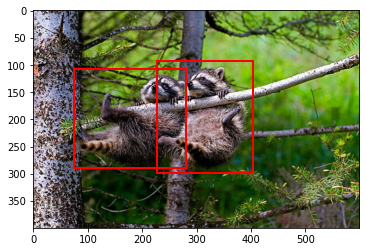

In [ ]:
#display boxes
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

#change PIL.Image to numpy array and add channel to last index
np_arr = np.array(img.getdata()).reshape(img.size[1], img.size[0], 3)

plt.imshow(np_arr)
ax = plt.gca()

#numpy array list of boxes
boxes = information[['xmin', 'ymin', 'xmax', 'ymax']].values

for box in boxes:
  rect = Rectangle((box[0], box[1]),
                    (box[2] - box[0]),
                    (box[3] - box[1]),
                    fill=False,
                    edgecolor=(1, 0, 0),
                    linewidth=2)
  ax.add_patch(rect)
  
plt.show()

## Custom dataset

In [ ]:
from torchvision.transforms import functional as F

class RaccoonDataset(torch.utils.data.Dataset):
  def __init__(self, root, phase):
    self.root = root
    self.phase = phase 
    self.targets = pd.read_csv(os.path.join(root, 'data/{}_labels.csv'.format(phase)))
    self.imgs = self.targets['filename']

  #what we want to give to our model
  def __getitem__(self, idx):

    #image
    img_path = os.path.join(self.root, 'images', self.imgs[idx])
    img = Image.open(img_path).convert('RGB')
    img = F.to_tensor(img) #convert PIL.Image to torch tensor
    
    #boxes
    box_list = self.targets[self.targets['filename'] == self.imgs[idx]]
    box_list = box_list[['xmin', 'ymin', 'xmax', 'ymax']].values
    boxes = torch.tensor(box_list, dtype=torch.float32)

    #lables
    labels = torch.ones((len(box_list), ), dtype=torch.int64)

    #targets
    target = {}
    target['boxes'] = boxes
    target['labels'] = labels
    
    return img, target

  def __len__(self):
    return len(self.imgs)

In [ ]:
train_dataset = RaccoonDataset('./raccoon_dataset/', 'train')
test_dataset = RaccoonDataset('./raccoon_dataset/', 'test')

In [ ]:
#sample item
train_dataset.__getitem__(10)

(tensor([[[0.7294, 0.7294, 0.7255,  ..., 0.4431, 0.4353, 0.4235],
          [0.7294, 0.7294, 0.7255,  ..., 0.4353, 0.4314, 0.4431],
          [0.7294, 0.7294, 0.7255,  ..., 0.4863, 0.4824, 0.4784],
          ...,
          [0.2980, 0.3333, 0.4314,  ..., 0.4353, 0.4588, 0.4588],
          [0.3490, 0.3412, 0.3294,  ..., 0.4118, 0.4275, 0.4235],
          [0.3569, 0.3412, 0.3686,  ..., 0.4157, 0.4275, 0.4275]],
 
         [[0.6314, 0.6314, 0.6314,  ..., 0.3529, 0.3412, 0.3294],
          [0.6314, 0.6314, 0.6314,  ..., 0.3412, 0.3373, 0.3490],
          [0.6314, 0.6314, 0.6314,  ..., 0.3922, 0.3882, 0.3843],
          ...,
          [0.2706, 0.3059, 0.4039,  ..., 0.3098, 0.3333, 0.3333],
          [0.3216, 0.3137, 0.3020,  ..., 0.2863, 0.3020, 0.2980],
          [0.3216, 0.3059, 0.3333,  ..., 0.2902, 0.3020, 0.3020]],
 
         [[0.4745, 0.4745, 0.4588,  ..., 0.2980, 0.2941, 0.2824],
          [0.4745, 0.4706, 0.4588,  ..., 0.2941, 0.2902, 0.3020],
          [0.4706, 0.4706, 0.4588,  ...,

## Data loader
* shuffle data<br>
* create batches<br>
* ...

In [ ]:
#dataloader concat images and targets and give tensor by default
#we want to have images and targets seprately
def new_concat(batch):
  return tuple(zip(*batch))

In [ ]:
#Data loader
train_loader = torch.utils.data.DataLoader(train_dataset,
                            batch_size=2,
                            shuffle=True,
                            collate_fn=new_concat)

test_loader = torch.utils.data.DataLoader(test_dataset,
                            batch_size=1,
                            shuffle=True,
                            collate_fn=new_concat)

In [ ]:
next(iter(train_loader))

((tensor([[[0.0824, 0.0824, 0.0784,  ..., 0.0392, 0.0392, 0.0392],
           [0.0784, 0.0784, 0.0745,  ..., 0.0392, 0.0392, 0.0392],
           [0.0706, 0.0706, 0.0667,  ..., 0.0392, 0.0392, 0.0392],
           ...,
           [0.1882, 0.1922, 0.1922,  ..., 0.1647, 0.1647, 0.1647],
           [0.1804, 0.1804, 0.1804,  ..., 0.1490, 0.1490, 0.1490],
           [0.1725, 0.1725, 0.1765,  ..., 0.1451, 0.1451, 0.1451]],
  
          [[0.0824, 0.0824, 0.0784,  ..., 0.0392, 0.0392, 0.0392],
           [0.0784, 0.0784, 0.0745,  ..., 0.0392, 0.0392, 0.0392],
           [0.0706, 0.0706, 0.0667,  ..., 0.0392, 0.0392, 0.0392],
           ...,
           [0.1882, 0.1922, 0.1922,  ..., 0.1647, 0.1647, 0.1647],
           [0.1804, 0.1804, 0.1804,  ..., 0.1490, 0.1490, 0.1490],
           [0.1725, 0.1725, 0.1765,  ..., 0.1451, 0.1451, 0.1451]],
  
          [[0.0824, 0.0824, 0.0784,  ..., 0.0392, 0.0392, 0.0392],
           [0.0784, 0.0784, 0.0745,  ..., 0.0392, 0.0392, 0.0392],
           [0.0706, 0.

In [ ]:
imgs, targets = next(iter(train_loader))
targets

({'boxes': tensor([[ 82.,  21., 187., 197.],
          [ 11.,  55.,  80., 145.]]), 'labels': tensor([1, 1])},
 {'boxes': tensor([[132.,  50., 305., 246.]]), 'labels': tensor([1])})

# Model

## models  with ***resnet50*** backbone

In [ ]:
#create resnet50 model
resnet_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

#out_features=  92 -> 2
resnet_model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(1024, 2)
resnet_model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### optimizer 1: ***SGD***

In [ ]:
optimizer_1 = torch.optim.SGD(resnet_model.parameters(), 
                            lr=0.005)
lr_scheduler_1 = torch.optim.lr_scheduler.StepLR(optimizer_1,
                                               step_size=3,
                                               gamma=0.1)

### optimizer 2: ***SGD Momentum***

In [ ]:
optimizer_2 = torch.optim.SGD(resnet_model.parameters(), 
                            lr=0.005, momentum=0.9)

lr_scheduler_2 = torch.optim.lr_scheduler.StepLR(optimizer_2,
                                               step_size=3,
                                               gamma=0.1)

### optimizer 3: ***SGD Momentum weight_decay***

In [ ]:
optimizer_3 = torch.optim.SGD(resnet_model.parameters(), 
                            lr=0.005, momentum=0.9, weight_decay=0.0008)

lr_scheduler_3 = torch.optim.lr_scheduler.StepLR(optimizer_3,
                                               step_size=3,
                                               gamma=0.1)

## model  with ***mobilenet_v2*** backbone

https://discuss.pytorch.org/t/maskrcnn-with-mobilenet-backbone/111837

In [ ]:
from torchvision.models.detection.rpn import AnchorGenerator

In [ ]:
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280

anchor_generator = AnchorGenerator(sizes=((32, 64, 128),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

box_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], 
                                                    output_size=7, 
                                                    sampling_ratio=2)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [ ]:
light_model = torchvision.models.detection.FasterRCNN(backbone=backbone, 
                                                      rpn_anchor_generator=anchor_generator,
                                                      box_roi_pool=box_roi_pooler,
                                                      num_classes=2)
light_model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(


### optimizer : ***SGD Momentum weight_decay***

In [ ]:
light_optimizer = torch.optim.SGD(light_model.parameters(), 
                            lr=0.001, momentum=0.9, weight_decay=0.0008)
light_lr_scheduler = torch.optim.lr_scheduler.StepLR(light_optimizer,
                                               step_size=3,
                                               gamma=0.7)

# Train

In [ ]:
import math
def train_one_epoch(model, optimizer, train_dataloader):
    model.train()
    total_loss = 0
    for images, targets in train_dataloader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        #calculate loss
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses
        optimizer.zero_grad()
        #optimizing
        losses.backward()
        optimizer.step()
    return total_loss/len(train_dataloader)

## train ***resnet50*** models

In [ ]:
#train resnet model optimizer: SGD
num_epochs = 10
model = resnet_model
dict1 = {}
for epoch in range(num_epochs):
    loss_1 = train_one_epoch(model, optimizer_1, train_loader)
    dict1[epoch] = float(loss_1.cpu().detach().numpy())
    lr_scheduler_1.step()
    print(f'epoch [{epoch}]:  \t lr: {lr_scheduler_1.get_last_lr()}  \t loss: {loss_1}  ')
print('backbone: resnet50, optimizer: SGD\n', dict1)

epoch [0]:  	 lr: [0.005]  	 loss: 0.23906825482845306  
epoch [1]:  	 lr: [0.005]  	 loss: 0.14593052864074707  
epoch [2]:  	 lr: [0.0005]  	 loss: 0.11503149569034576  
epoch [3]:  	 lr: [0.0005]  	 loss: 0.09726031124591827  
epoch [4]:  	 lr: [0.0005]  	 loss: 0.09543923288583755  
epoch [5]:  	 lr: [5e-05]  	 loss: 0.09296727180480957  
epoch [6]:  	 lr: [5e-05]  	 loss: 0.09172710031270981  
epoch [7]:  	 lr: [5e-05]  	 loss: 0.0920213833451271  
epoch [8]:  	 lr: [5e-06]  	 loss: 0.09002673625946045  
epoch [9]:  	 lr: [5e-06]  	 loss: 0.09163390845060349  
backbone: resnet50, optimizer: SGD
 {0: 0.23906825482845306, 1: 0.14593052864074707, 2: 0.11503149569034576, 3: 0.09726031124591827, 4: 0.09543923288583755, 5: 0.09296727180480957, 6: 0.09172710031270981, 7: 0.0920213833451271, 8: 0.09002673625946045, 9: 0.09163390845060349}


In [ ]:
#train resnet model, optimizer: SGD + Momentum
#first reset model "please run moodel cell"
num_epochs = 10
model = resnet_model
dict2 = {}
for epoch in range(num_epochs):
    loss_2 = train_one_epoch(model, optimizer_2, train_loader)
    dict2[epoch] = float(loss_2.cpu().detach().numpy())
    lr_scheduler_2.step()
    print(f'epoch [{epoch}]:  \t lr: {lr_scheduler_2.get_last_lr()}  \t loss: {loss_2}  ')
print('backbone: resnet50, optimizer: SGD + Momentum\n', dict2)

epoch [0]:  	 lr: [0.005]  	 loss: 0.19206878542900085  
epoch [1]:  	 lr: [0.005]  	 loss: 0.10037096589803696  
epoch [2]:  	 lr: [0.0005]  	 loss: 0.07534044235944748  
epoch [3]:  	 lr: [0.0005]  	 loss: 0.05975959077477455  
epoch [4]:  	 lr: [0.0005]  	 loss: 0.05037936940789223  
epoch [5]:  	 lr: [5e-05]  	 loss: 0.04760122299194336  
epoch [6]:  	 lr: [5e-05]  	 loss: 0.04401402547955513  
epoch [7]:  	 lr: [5e-05]  	 loss: 0.04373014718294144  
epoch [8]:  	 lr: [5e-06]  	 loss: 0.043966878205537796  
epoch [9]:  	 lr: [5e-06]  	 loss: 0.04333403334021568  
backbone: resnet50, optimizer: SGD + Momentum
 {0: 0.19206878542900085, 1: 0.10037096589803696, 2: 0.07534044235944748, 3: 0.05975959077477455, 4: 0.05037936940789223, 5: 0.04760122299194336, 6: 0.04401402547955513, 7: 0.04373014718294144, 8: 0.043966878205537796, 9: 0.04333403334021568}


In [ ]:
#train resnet model, optimizer: SGD + Momentum + weight_decay
#first reset model "please run moodel cell"
num_epochs = 10
model = resnet_model
dict3 = {}
for epoch in range(num_epochs):
    loss_3 = train_one_epoch(model, optimizer_3, train_loader)
    dict3[epoch] = float(loss_3.cpu().detach().numpy())
    lr_scheduler_3.step()
    print(f'epoch [{epoch}]:  \t lr: {lr_scheduler_3.get_last_lr()}  \t loss: {loss_3}  ')
print('backbone: resnet50, optimizer: SGD + Momentum + weight_decay\n', dict3)

epoch [0]:  	 lr: [0.005]  	 loss: 0.1978999674320221  
epoch [1]:  	 lr: [0.005]  	 loss: 0.1036696583032608  
epoch [2]:  	 lr: [0.0005]  	 loss: 0.08084581792354584  
epoch [3]:  	 lr: [0.0005]  	 loss: 0.05865839868783951  
epoch [4]:  	 lr: [0.0005]  	 loss: 0.051022160798311234  
epoch [5]:  	 lr: [5e-05]  	 loss: 0.04801340028643608  
epoch [6]:  	 lr: [5e-05]  	 loss: 0.04583305865526199  
epoch [7]:  	 lr: [5e-05]  	 loss: 0.045158885419368744  
epoch [8]:  	 lr: [5e-06]  	 loss: 0.04497438296675682  
epoch [9]:  	 lr: [5e-06]  	 loss: 0.044314462691545486  
backbone: resnet50, optimizer: SGD + Momentum + weight_decay
 {0: 0.1978999674320221, 1: 0.1036696583032608, 2: 0.08084581792354584, 3: 0.05865839868783951, 4: 0.051022160798311234, 5: 0.04801340028643608, 6: 0.04583305865526199, 7: 0.045158885419368744, 8: 0.04497438296675682, 9: 0.044314462691545486}


## train ***mobilenet_v2*** model

In [ ]:
#train mobilenet model optimizer: SGD + Momentum + weight_decay
num_epochs = 10
model = light_model
light_dict = {}
for epoch in range(num_epochs):
    light_loss = train_one_epoch(model, light_optimizer, train_loader)
    light_dict[epoch] = float(light_loss.cpu().detach().numpy())
    light_lr_scheduler.step()
    print(f'epoch [{epoch}]:  \t lr: {light_lr_scheduler.get_last_lr()}  \t loss: {light_loss}  ')
print('backbone: mobilenet, optimizer: SGD + Momentum + weight_decay\n', light_dict)

epoch [0]:  	 lr: [0.001]  	 loss: 1.6662325859069824  
epoch [1]:  	 lr: [0.001]  	 loss: 1.168940782546997  
epoch [2]:  	 lr: [0.0007]  	 loss: 0.9984908699989319  
epoch [3]:  	 lr: [0.0007]  	 loss: 0.8479897379875183  
epoch [4]:  	 lr: [0.0007]  	 loss: 0.7889596223831177  
epoch [5]:  	 lr: [0.00049]  	 loss: 0.7214080095291138  
epoch [6]:  	 lr: [0.00049]  	 loss: 0.6583783626556396  
epoch [7]:  	 lr: [0.00049]  	 loss: 0.6526705026626587  
epoch [8]:  	 lr: [0.000343]  	 loss: 0.6106132864952087  
epoch [9]:  	 lr: [0.000343]  	 loss: 0.585443377494812  
backbone: mobilenet, optimizer: SGD + Momentum + weight_decay
 {0: 1.6662325859069824, 1: 1.168940782546997, 2: 0.9984908699989319, 3: 0.8479897379875183, 4: 0.7889596223831177, 5: 0.7214080095291138, 6: 0.6583783626556396, 7: 0.6526705026626587, 8: 0.6106132864952087, 9: 0.585443377494812}


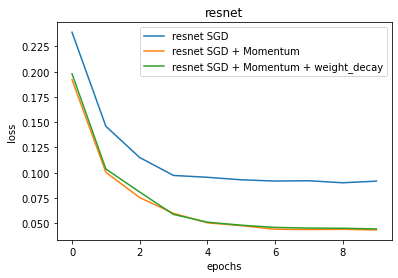

In [ ]:
x = [i for i in range(num_epochs)]

y1 = [dict1[i] for i in range(num_epochs)]
y2 = [dict2[i] for i in range(num_epochs)]
y3 = [dict3[i] for i in range(num_epochs)]
y4 = [light_dict[i] for i in range(num_epochs)]

plt.plot(x, y1, label = "resnet SGD")
plt.plot(x, y2, label = "resnet SGD + Momentum")
plt.plot(x, y3, label = "resnet SGD + Momentum + weight_decay")
#plt.plot(x, y4, label = "mobilenet SGD + Momentum + weight_decay")

plt.xlabel('epochs')
plt.ylabel('loss')

plt.title('resnet')

plt.legend()

plt.show()

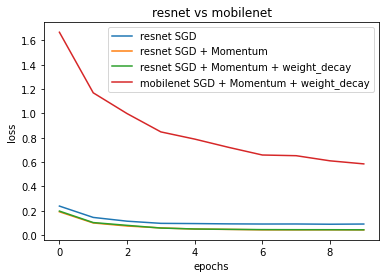

In [ ]:
plt.plot(x, y1, label = "resnet SGD")
plt.plot(x, y2, label = "resnet SGD + Momentum")
plt.plot(x, y3, label = "resnet SGD + Momentum + weight_decay")
plt.plot(x, y4, label = "mobilenet SGD + Momentum + weight_decay")

plt.xlabel('epochs')
plt.ylabel('loss')

plt.title('resnet vs mobilenet')

plt.legend()

plt.show()

# Evaluate

In [ ]:
#create folder for output images
! mkdir /content/output_images

In [ ]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def evaluate(model, test_dataloader):
    model.eval()
    with torch.no_grad():
        cnt = 0
        for images , targets in test_dataloader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            #model output
            out = model(images)
            scores = out[0]['scores'].cpu().numpy()
            inds = scores > 0.7
            bxs = out[0]['boxes'].cpu().numpy()
            bxs = bxs[inds]
            gt = targets[0]['boxes'].cpu().numpy()
            # gt = gt[0]
            img = images[0].permute(1, 2, 0).cpu().numpy()
            #----------------------------------------------------------
            fig, ax = plt.subplots(1)
            ax.imshow(img)
            #green is correct boxes
            for j in range(len(gt)):
                rect1 = patches.Rectangle((int(gt[j][0]),int(gt[j][1])),abs(gt[j][0]-gt[j][2]),
                                abs(gt[j][1]-gt[j][3]),linewidth=3,edgecolor='g',facecolor='none')
                ax.add_patch(rect1)
            #red is model guess
            for i in range(len(bxs)):
                rect = patches.Rectangle((int(bxs[i][0]),int(bxs[i][1])),abs(bxs[i][0]-bxs[i][2]),
                                         abs(bxs[i][1]-bxs[i][3]),linewidth=3,edgecolor='r',facecolor='none')
                ax.add_patch(rect)
            fig.savefig("/content/output_images/{}.png".format(cnt), dpi=90, bbox_inches='tight')
            cnt = cnt + 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


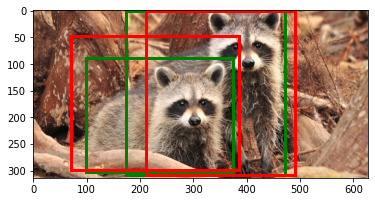

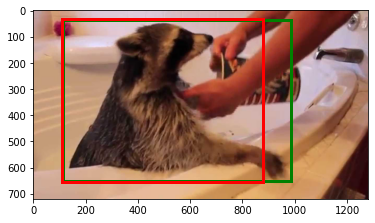

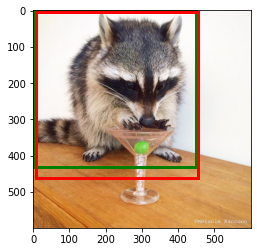

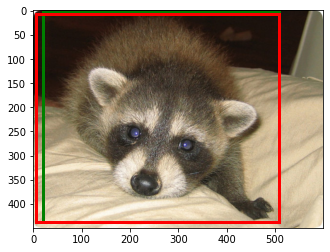

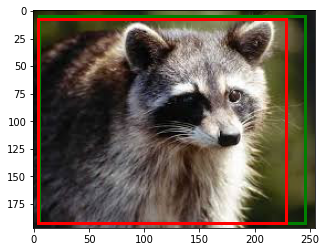

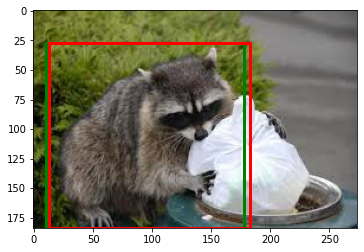

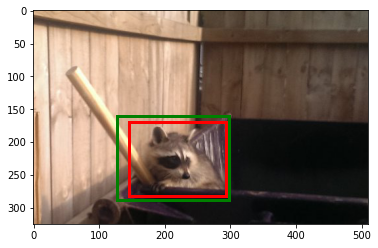

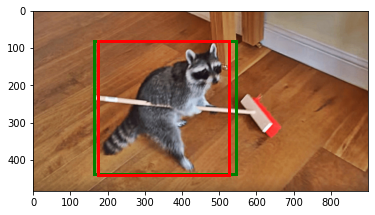

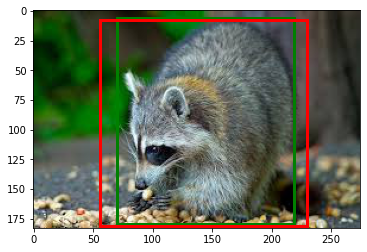

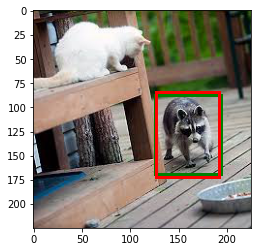

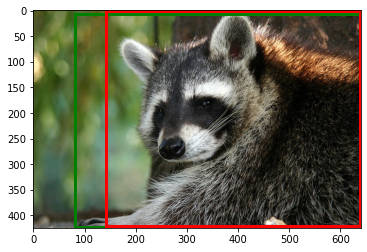

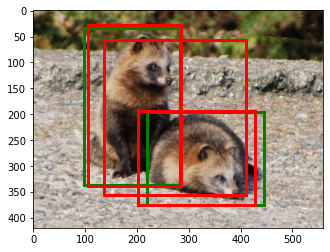

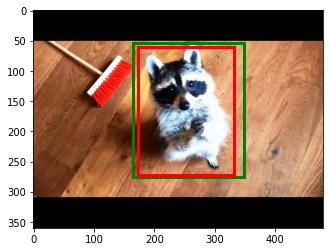

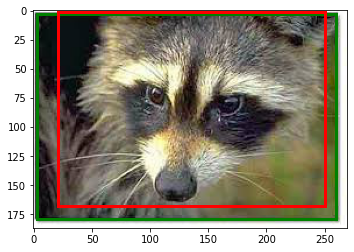

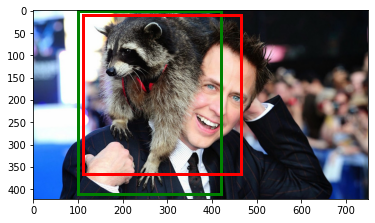

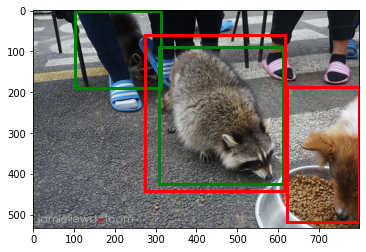

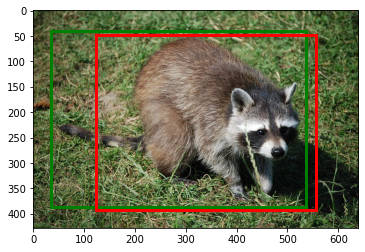

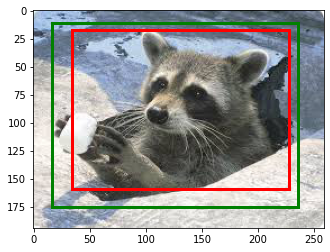

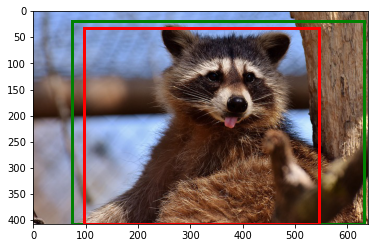

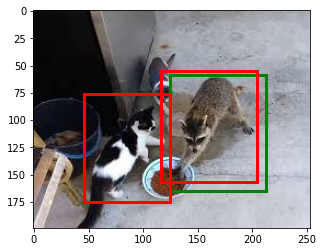

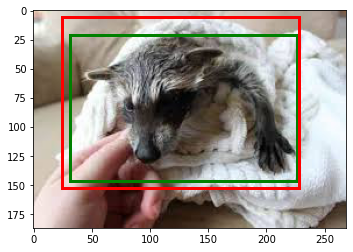

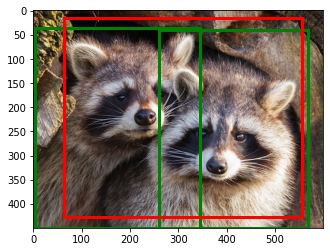

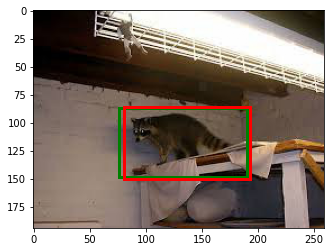

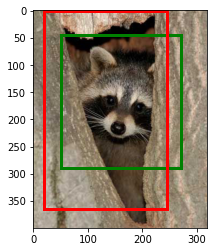

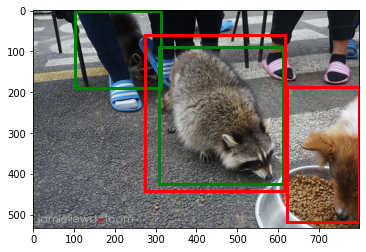

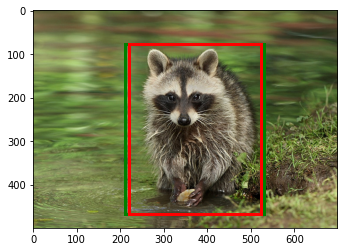

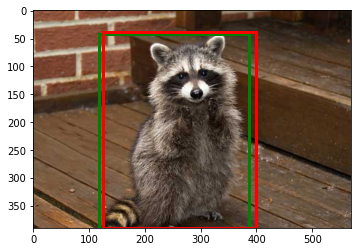

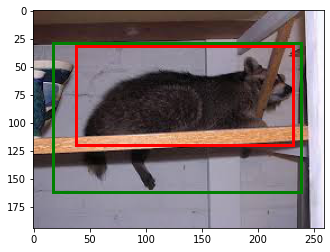

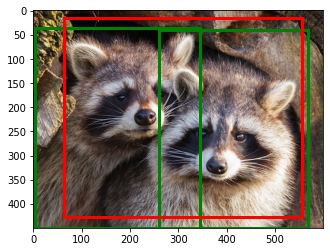

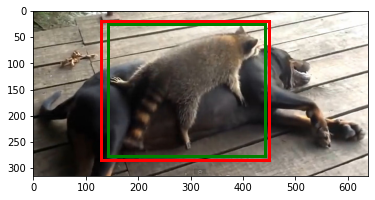

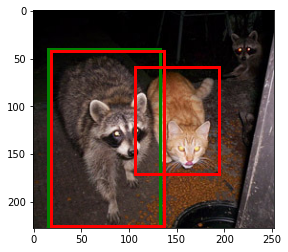

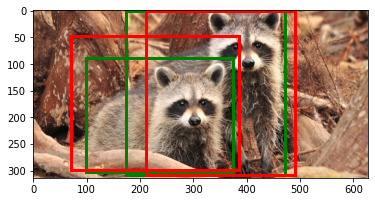

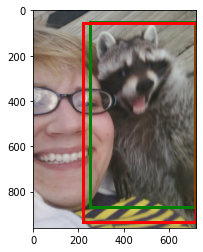

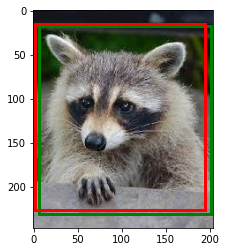

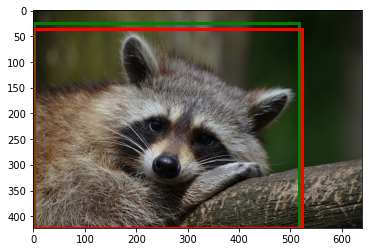

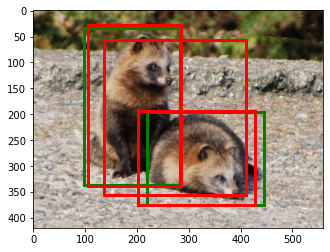

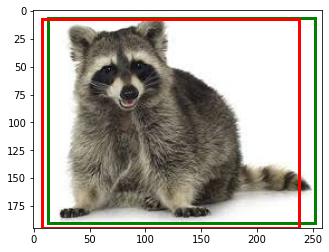

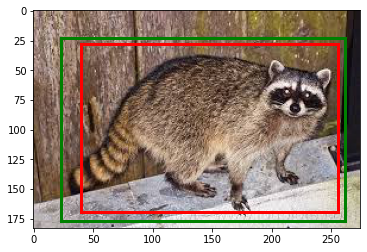

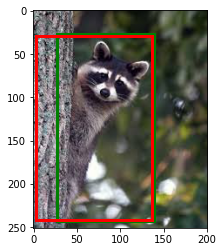

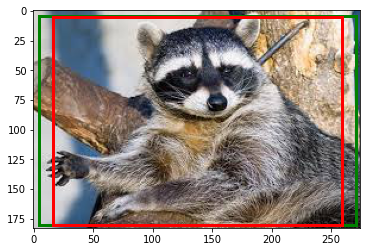

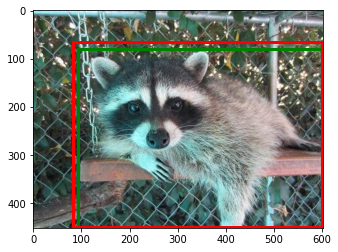

In [ ]:
#red is model guess
#use resnet model with optimizer 3
evaluate(resnet_model, test_loader)